<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10_ScratchFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [6]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [7]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/lib2')
!ls '/content/drive/My Drive/EVA4/lib2'

AlbTestTransforms.py   displayData.py  LR_Finder.py  rohan_library.py
AlbTrainTransforms.py  execute.py      __pycache__
DataLoaders.py	       Gradcam.py      resNet.py


**Import required libraries**

In [8]:
from rohan_library import *
# import execute
from resNet import ResNet18
import displayData as display
# import Gradcam 
# from Gradcam import GRADCAM, PLOT
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
# import LR_Finder

REQUIRED LIBRARIES LOADED...


**Albumentations**

In [0]:
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [10]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [12]:
dataiter = iter(trainLoader)
# iter(trainLoader).next()

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

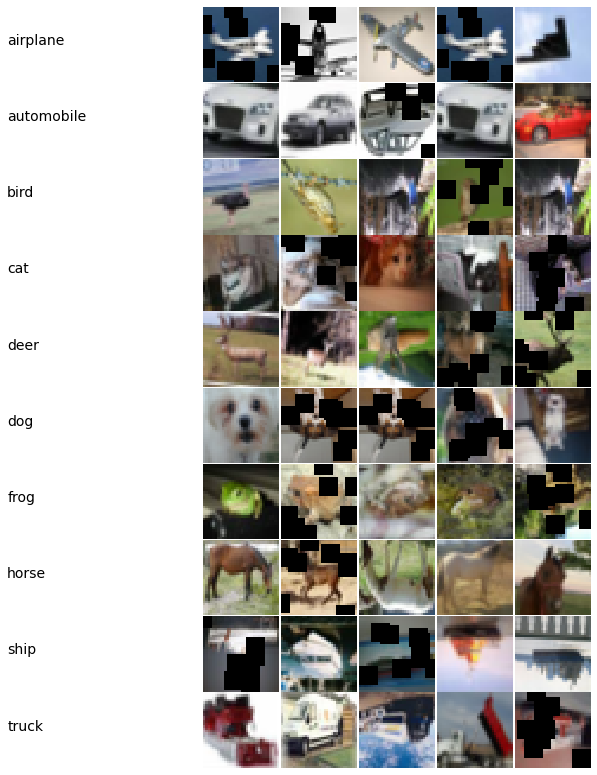

In [13]:
display.classImages(trainLoader)

**Model Summary**

In [14]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**Train & Test Class**

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, trainloader, optimizer, epoch, criterion, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      c_loss = criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss = c_loss +  (L1lambda * l1_loss)

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      # scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, testloader, filename, criterion, correct_samples, correctLabels, incorrect_samples):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  
            test_loss = criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()  
            
            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam
                
      self.test_losses.append(test_loss)      

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    
      self.test_acc.append(100. * correct / len(testloader.dataset))




def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
  """
  Returns Summary of the model passed in as model
  """
  return summary(model, input_size)


**LR Finder**

In [16]:
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from packaging import version

PYTORCH_VERSION = version.parse(torch.__version__)

try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    import logging

    logging.basicConfig()
    logger = logging.getLogger(__name__)
    logger.warning(
        "To enable mixed precision training, please install `apex`. "
        "Or you can re-install this package by the following command:\n"
        '  pip install torch-lr-finder -v --global-option="amp"'
    )
    IS_AMP_AVAILABLE = False
    del logging


class DataLoaderIter(object):
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self._iterator = iter(data_loader)

    @property
    def dataset(self):
        return self.data_loader.dataset

    def inputs_labels_from_batch(self, batch_data):
        if not isinstance(batch_data, list) and not isinstance(batch_data, tuple):
            raise ValueError("""Your batch type not supported: {}. Please inherit from `TrainDataLoaderIter`
                (or `ValDataLoaderIter`) and redefine
                `_batch_make_inputs_labels` method.""".format(type(batch_data)))

        inputs, labels, *_ = batch_data

        return inputs, labels

    def __iter__(self):
        return self

    def __next__(self):
        batch = next(self._iterator)
        return self.inputs_labels_from_batch(batch)


class TrainDataLoaderIter(DataLoaderIter):
    def __init__(self, data_loader, auto_reset=True):
        super().__init__(data_loader)
        self.auto_reset = auto_reset

    def __next__(self):
        try:
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)

        return inputs, labels


class ValDataLoaderIter(DataLoaderIter):
    pass



class LRFinder(object):
        def __init__(self, model, optimizer, criterion, device=None, memory_cache = True, cache_dir = None):
          self.optimizer = optimizer # check whether the optimizer is attached to the scheduler
          # self._check_for_scheduler()

          self.model = model
          self.criterion = criterion
          self.history = {'lr':[], 'loss':[]}
          self.bestLoss = None
          self.memory_cache = memory_cache

          # Save the original state of model & optimizer(MODEL & OPTIMIZER STATE BEFORE THE LR FINDER PROCESS)
          self.model_device = next(self.model.parameters()).device
          self.state_cacher = StateCacher(memory_cache, cache_dir= cache_dir)
          self.state_cacher.store('Model', self.model.state_dict())
          self.state_cacher.store('Optimizer', self.optimizer.state_dict())

          # If device is none then change it to default model_device
          if device:
              self.device = device
          else:
              self.device = self.model_device

        def reset(self):
            """ Restores Model & Optimizer to their initial states"""
            self.model.load_state_dict(self.state_cacher.retrieve('Model'))
            self.optimizer.load_state_dict(self.state_cacher.retrieve('Optimizer'))
            self.model.to(self.device) # CHANGED FROM self.model_device to self.device

        
        def range_test(
                    self, train_loader,  val_loader=None,
                    start_lr=None, end_lr=10, num_iter=100, 
                    step_mode='linear', smooth_f=0.05, diverge_th=5, 
                    accumulation_steps = 1, non_blocking_transfer = True):
                    
            self.history = {'lr':[], 'loss':[]}
            self.bestLoss = None

            # move the model to the device
            self.model.to(self.device)

            # check whether the optimizer is attached to the scheduler
            self._check_for_scheduler()

            # set the start of learning rate
            if start_lr:
                self._set_learning_rate(start_lr)

            # Initialize learning rate policy
            if step_mode.lower() == 'exp':
                lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
            elif step_mode.lower() == 'linear':
                lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
            else:
                raise ValueError('expected one of (exp, linear), got {a}'.format(a=step_mode))


            if smooth_f < 0 or smooth_f >= 1:
                raise ValueError('smooth_f is outside the range of [0,1]')


            # Create an iterator to get data batch by batch
            if isinstance(train_loader, DataLoader):
                train_iter = TrainDataLoaderIter(train_loader)
            elif isinstance(train_loader, TrainDataLoaderIter):
                train_iter = train_loader
            else:
                raise ValueError("""`train_loader` has unsupported type: {}.
                    Expected types are `torch.utils.data.DataLoader`
                    or child of `TrainDataLoaderIter`.""".format(type(train_loader)))

            if val_loader:
                if isinstance(val_loader, DataLoader):
                    val_iter = ValDataLoaderIter(val_loader)
                elif isinstance(val_loader, ValDataLoaderIter):
                    val_iter = val_loader
                else:
                    raise ValueError("""`val_loader` has unsupported type: {}.
                        Expected types are `torch.utils.data.DataLoader`
                        or child of `ValDataLoaderIter`.""".format(type(val_loader)))

            
            for iteration in tqdm(range(num_iter)):
                # Train on batch and retrieve loss
                # print(train_iter)
                loss = self._train_batch(train_iter, accumulation_steps, non_blocking_transfer=non_blocking_transfer)
           
                if val_loader:
                    loss = self._validate(
                    val_iter, non_blocking_transfer=non_blocking_transfer)

                # Update Learning Rate
                self.history['lr'].append(lr_schedule.get_lr()[0])
                lr_schedule.step()

                # Track the best loss
                if iteration == 0:
                    self.bestLoss = loss
                else:
                    if smooth_f>0:
                        loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                    if loss < self.bestLoss:
                        self.bestLoss = loss
                
                # check if the loss has diverged it needs to be stopped
                self.history['loss'].append(loss)
                if loss > diverge_th*self.bestLoss:
                    print('The loss has diverged, Stopping Early!')
                    break
     

        def _set_learning_rate(self, new_lrs):
            if not isinstance(new_lrs, list):
              new_lrs = [new_lrs] * len(self.optimizer.param_groups)
            if len(new_lrs) != len(self.optimizer.param_groups):
                  raise ValueError("Length of `new_lrs` is not equal to the number of parameter groups "+"in the given optimizer")

            for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
                param_group["lr"] = new_lr


        def _check_for_scheduler(self):
            for param_group in self.optimizer.param_groups:
                if "initial_lr" in param_group:
                    raise RuntimeError ("Optimizer has already a scheduler attached to it.")

        def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
          self.model.train()
          total_loss = None  # for late initialization

          self.optimizer.zero_grad()
          for i in range(accumulation_steps):
            inputs, labels = train_iter.__next__()
            inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)
        

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

            self.optimizer.step()
            return total_loss.item()

        def _move_to_device(self, inputs, labels, non_blocking=True):
          def move(obj, device, non_blocking=True):
            if hasattr(obj, "to"):
                return obj.to(device, non_blocking=non_blocking)
            elif isinstance(obj, tuple):
                return tuple(move(o, device, non_blocking) for o in obj)
            elif isinstance(obj, list):
                return [move(o, device, non_blocking) for o in obj]
            elif isinstance(obj, dict):
                return {k: move(o, device, non_blocking) for k, o in obj.items()}
            else:
                return obj

          inputs = move(inputs, self.device, non_blocking=non_blocking)
          labels = move(labels, self.device, non_blocking=non_blocking)
          return inputs, labels

        def _validate(self, val_iter, non_blocking_transfer=True):
          # Set model to evaluation mode and disable gradient computation
          running_loss = 0
          self.model.eval()
          with torch.no_grad():
              for inputs, labels in val_iter:
                  # Move data to the correct device
                  inputs, labels = self._move_to_device(
                      inputs, labels, non_blocking=non_blocking_transfer
                  )

                  if isinstance(inputs, tuple) or isinstance(inputs, list):
                      batch_size = inputs[0].size(0)
                  else:
                      batch_size = inputs.size(0)

                  # Forward pass and loss computation
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  running_loss += loss.item() * batch_size

          return running_loss / len(val_iter.dataset)

        def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
          """Plots the learning rate range test.
          Arguments:
              skip_start (int, optional): number of batches to trim from the start.
                  Default: 10.
              skip_end (int, optional): number of batches to trim from the start.
                  Default: 5.
              log_lr (bool, optional): True to plot the learning rate in a logarithmic
                  scale; otherwise, plotted in a linear scale. Default: True.
              show_lr (float, optional): if set, adds a vertical line to visualize the
                  specified learning rate. Default: None.
              ax (matplotlib.axes.Axes, optional): the plot is created in the specified
                  matplotlib axes object and the figure is not be shown. If `None`, then
                  the figure and axes object are created in this method and the figure is
                  shown . Default: None.
          Returns:
              The matplotlib.axes.Axes object that contains the plot.
          """

          if skip_start < 0:
              raise ValueError("skip_start cannot be negative")
          if skip_end < 0:
              raise ValueError("skip_end cannot be negative")
          if show_lr is not None and not isinstance(show_lr, float):
              raise ValueError("show_lr must be float")

          # Get the data to plot from the history dictionary. Also, handle skip_end=0
          # properly so the behaviour is the expected
          lrs = self.history["lr"]
          losses = self.history["loss"]
          if skip_end == 0:
              lrs = lrs[skip_start:]
              losses = losses[skip_start:]
          else:
              lrs = lrs[skip_start:-skip_end]
              losses = losses[skip_start:-skip_end]

          # Create the figure and axes object if axes was not already given
          fig = None
          if ax is None:
              fig, ax = plt.subplots()

          # Plot loss as a function of the learning rate
          ax.plot(lrs, losses)
          if log_lr:
              ax.set_xscale("log")
          ax.set_xlabel("Learning rate")
          ax.set_ylabel("Loss")

          if show_lr is not None:
              ax.axvline(x=show_lr, color="red")

          # Show only if the figure was created internally
          if fig is not None:
              plt.show()

          return ax


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(fn)
                )
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


  pip install torch-lr-finder -v --global-option="amp"


**Installing Apex**

In [0]:
# pip install torch-lr-finder -v --global-option="amp"

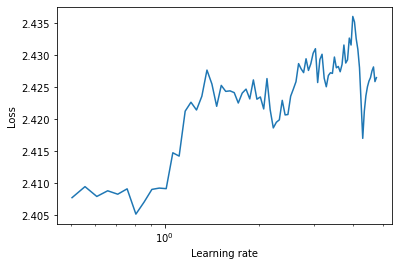

In [18]:
torch.manual_seed(10)
criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-6, weight_decay=1e-4)
model = ResNet18().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(trainLoader,  end_lr = 5, num_iter = 100)#, step_mode = 'exp')
lr_finder.plot()

In [19]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.bestLoss)]
Best_lr


0.20202116161616163

In [0]:
lr_finder.reset()

**Modelling**

In [31]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-4, nesterov = True)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=len(trainLoader), epochs = 25)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)



model1 = Test_Train()
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(model, device, trainLoader, optimizer, epoch, criterion, L1lambda = 1e-5 )
  model1.test(model, device, testLoader, 'model1.pt', criterion, correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

EPOCH:  1



Validation loss has  decreased (inf --> 1.3651).  Saving model ...

Test set: Average loss: 1.3651, Accuracy: 5268/10000 (52.68%)

EPOCH:  2



Validation loss has  decreased (1.3651 --> 0.9269).  Saving model ...

Test set: Average loss: 0.9269, Accuracy: 5794/10000 (57.94%)

EPOCH:  3




Test set: Average loss: 0.9843, Accuracy: 6422/10000 (64.22%)

EPOCH:  4



Validation loss has  decreased (0.9269 --> 0.5435).  Saving model ...

Test set: Average loss: 0.5435, Accuracy: 6980/10000 (69.80%)

EPOCH:  5



Validation loss has  decreased (0.5435 --> 0.3495).  Saving model ...

Test set: Average loss: 0.3495, Accuracy: 7308/10000 (73.08%)

EPOCH:  6




Test set: Average loss: 0.8999, Accuracy: 7460/10000 (74.60%)

EPOCH:  7




Test set: Average loss: 0.3711, Accuracy: 7470/10000 (74.70%)

EPOCH:  8




Test set: Average loss: 0.6348, Accuracy: 7644/10000 (76.44%)

EPOCH:  9




Test set: Average loss: 0.5280, Accuracy: 8274/10000 (82.74%)

EPOCH:  10




Test set: Average loss: 1.1396, Accuracy: 8303/10000 (83.03%)



In [23]:
type(model1.test_losses)

list

**Plot Train & Test Curves**

Text(0.5, 1.0, 'Test Accuracy')

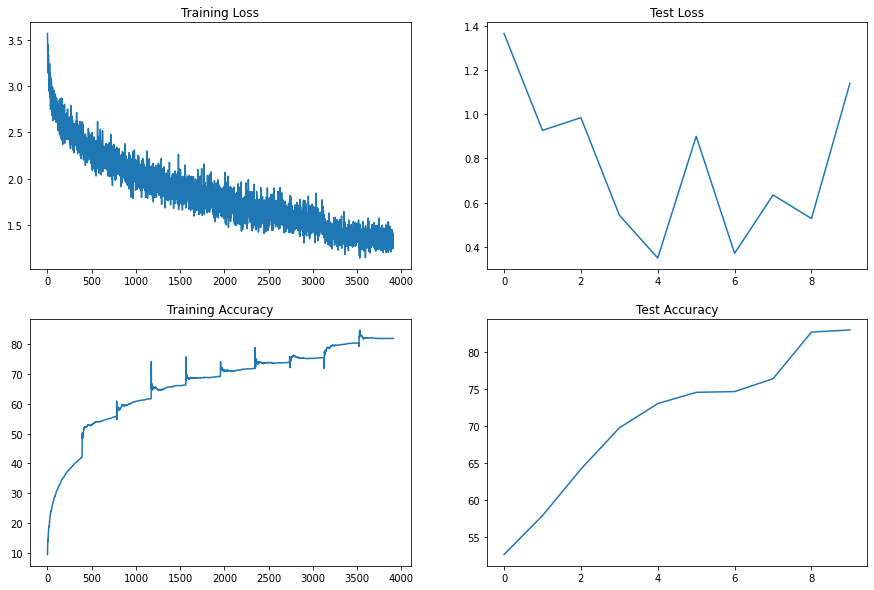

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(model1.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(model1.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(model1.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(model1.test_acc)
axs[1, 1].set_title("Test Accuracy")

**Data for GradCam**

In [33]:

images = [x['image'] for x in incorrectSamples[10:14]]
target_classes = [l['label'] for l in incorrectSamples[10:14]]
# print(images)
for i in target_classes:
  print(classes[i])


horse
truck
cat
deer


**GradCam Implementation**

In [71]:

images = [x['image'] for x in incorrectSamples[10:14]]
target_classes = [l['label'] for l in incorrectSamples[10:14]]
predicted_classes = [p['prediction'] for p in incorrectSamples[10:14]]
# print(images)
print('***target-classes***')
tc = [classes[t] for t in target_classes]
tc

print('***predicted-classes***')
pc = [classes[p] for p in predicted_classes]
pc
# for p in predicted_classes:
#   print(classes[p])
# print('predicted
# predicted_labels

***target-classes***


['horse', 'truck', 'cat', 'deer']

In [47]:
type(p)
p

tensor([3], device='cuda:0')

In [0]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM():
    """ Helper Class for extracting activations and
    registering gradients from target(intermediate) layers
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output): # this will return Input & Output of  a layer during Forward Pass
              self.fmap_pool[key] = output.detach() #

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out): # this will return Input & Output of a layer during Backward Pass
              self.grad_pool[key] = grad_out[0].detach() #

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name))) # appending I/P & O/P of a layer during forward pass
                self.handlers.append(module.register_backward_hook(save_grads(name))) # same during backward pass

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)  # creating a one hot tensor of self.nll shape, but filled with zeros
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0) # replacing ids with 1.0 at dim = 1
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam





def GRADCAM(images, device, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(device)
  # set up grad cam
  gcam = GradCAM(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids



def PLOT(gcam_layers, images, target_layers, image_size, unnormalize, tc, pc):
    """
    ***Arguments***:
    gcam_layers:
    images: set of images(both correctly classified and misclassified)
    target_layers: set of layers where you want to plot GradCAM
    image_size: size of image
    unnormalize: de/unnormalizing the image
    tc: actual/target class labels
    pc: predicted class labels
    """

    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(32,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f'pred={pc[j]}\n[actual={tc[j]}]', fontsize=14)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')


        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')

        plt.axis('off')
    plt.show()


torch.Size([4, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


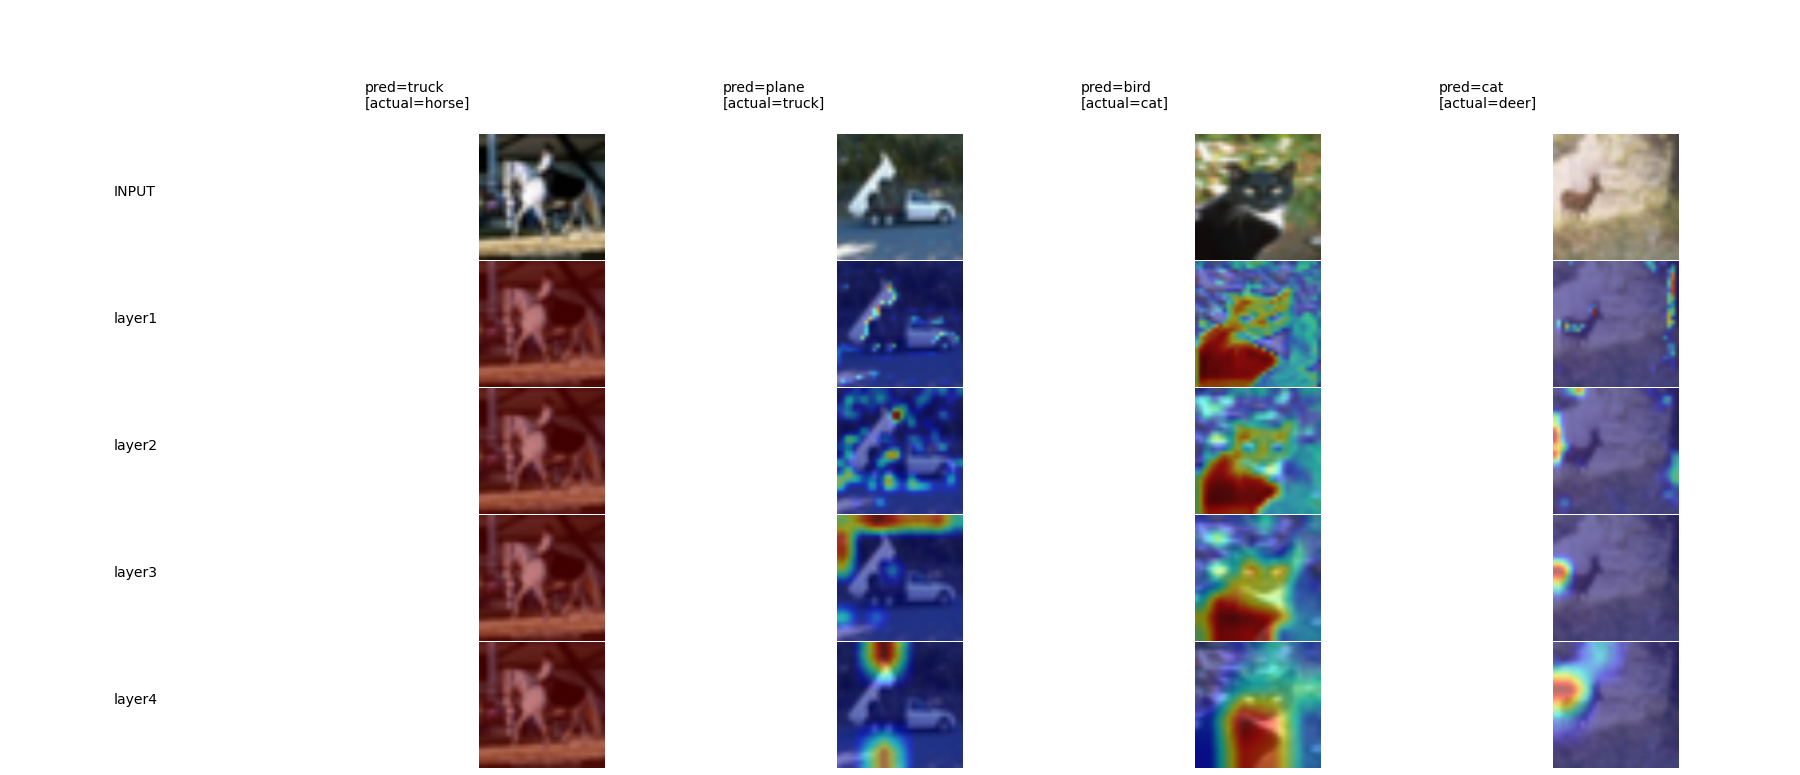

In [81]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


<Figure size 936x936 with 0 Axes>

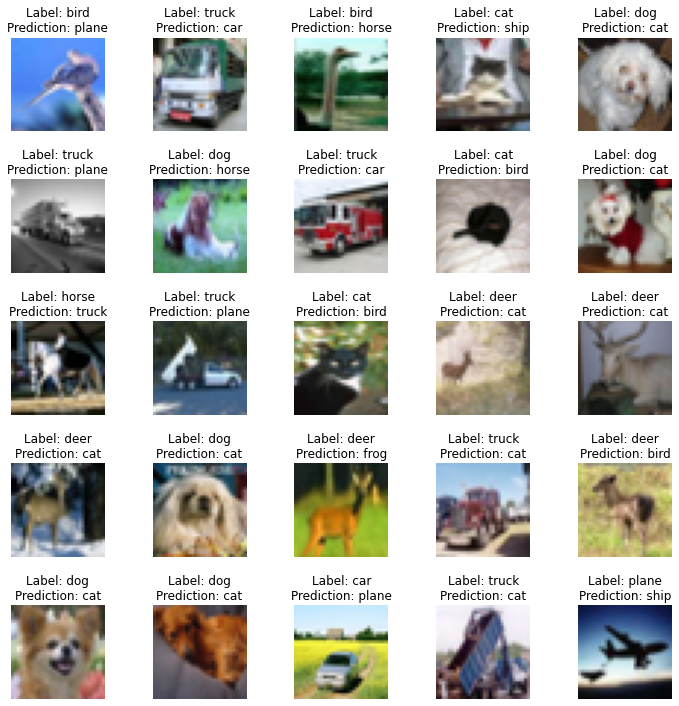

In [77]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')